In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install keras-preprocessing
!pip install nltk
!pip install textblob
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Define text preprocessing function using NLTK
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Join tokens back to string format
    return " ".join(tokens)

# Define a function to extract sentiment polarity using TextBlob
def get_combined_sentiment(text):
    blob_sentiment = TextBlob(text).sentiment.polarity
    vader_sentiment = vader_analyzer.polarity_scores(text)['compound']
    return (blob_sentiment + vader_sentiment) / 2

# Load the dataset
train_data = pd.read_csv('/content/drive/My Drive/nlp-getting-started/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/nlp-getting-started/test.csv')

In [ ]:
train_data['cleaned_text'] = train_data['text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['text'].apply(preprocess_text)

# Extract sentiment from the cleaned text using both TextBlob and VADER
train_data['sentiment'] = train_data['cleaned_text'].apply(get_combined_sentiment)
test_data['sentiment'] = test_data['cleaned_text'].apply(get_combined_sentiment)

print(train_data[['cleaned_text', 'sentiment']].head())

                                        cleaned_text  sentiment
0         deed reason earthquake may allah forgive u     0.1366
1              forest fire near la ronge sask canada    -0.1200
2  resident asked place notified officer evacuati...    -0.0500
3  people receive wildfire evacuation order calif...     0.0000
4  got sent photo ruby alaska smoke wildfire pour...     0.0000


In [ ]:
from sklearn.model_selection import train_test_split

X = train_data[['cleaned_text', 'sentiment']]  # X contains both cleaned_text and sentiment
y = train_data["target"]  # y contains the target labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=256,
                                                                   name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor=preprocessor,
                                                               num_classes=2)

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

classifier.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

# Fit the model
history = classifier.fit(x=X_train['cleaned_text'],
                         y=y_train,
                         batch_size=32,
                         epochs=20,  # Increased epochs for better training
                         validation_data=(X_val['cleaned_text'], y_val))

# Evaluate on Training Data
y_pred_train = classifier.predict(X_train['cleaned_text'])
y_pred_val = classifier.predict(X_val['cleaned_text'])


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.9868 - loss: 0.0231 - val_accuracy: 0.7859 - val_loss: 1.2354
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9891 - loss: 0.0226 - val_accuracy: 0.7853 - val_loss: 1.3780
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9887 - loss: 0.0232 - val_accuracy: 0.7866 - val_loss: 1.4156
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9892 - loss: 0.0228 - val_accuracy: 0.7866 - val_loss: 1.3938
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9889 - loss: 0.0225 - val_accuracy: 0.7905 - val_loss: 1.4468
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9893 - loss: 0.0219 - val_accuracy: 0.7794 - val_loss: 1.5214
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9878 - loss: 0.0238 - val_accuracy: 0.7873 - val_loss: 1.4568
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9894 - loss: 0.0204 -

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

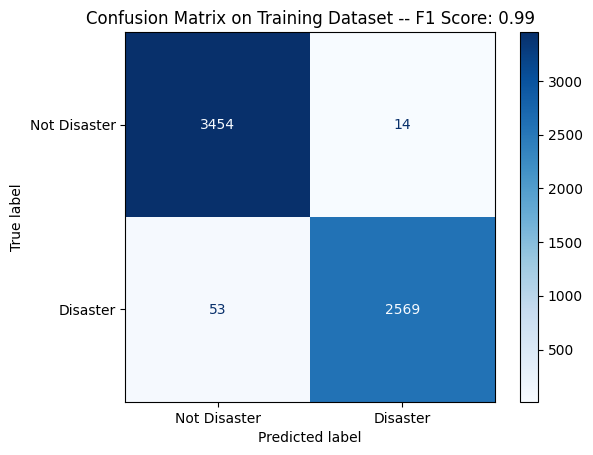

In [ ]:
# Display the confusion matrix for training data
displayConfusionMatrix(y_train, y_pred_train, "Training")

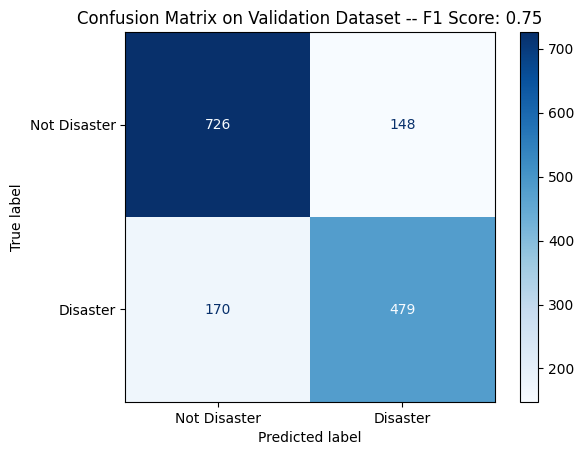

In [ ]:
displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [ ]:
# Preprocess the test data (use 'cleaned_text' as done for training and validation)
X_test_cleaned = test_data['cleaned_text']

# Predict labels on the test set using the trained classifier
y_pred_test = classifier.predict(X_test_cleaned)

# Convert predictions to binary labels (0 or 1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


In [ ]:
submission = pd.DataFrame({
    'id': test_data['id'],  # Assuming 'id' column exists in the test dataset
    'target': y_pred_test_labels  # Predicted binary labels
})

# Save the submission file to CSV
submission.to_csv('/content/drive/My Drive/nlp-getting-started/submission.csv', index=False)

# Check the first few rows of the submission file
print(submission.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
